In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssdlight300_shufflenetv2 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
import tensorflow as tf

run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                input_tensor=tf.placeholder('float32', shape=(1,300,300,3)),
                mode='inference',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)
    
# Factor 1.5
print("{:,} --- {:,}".format(flops.total_float_ops/2, params.total_parameters))

665,752,858.0 --- 5,722,900


## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 245.75it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 70:
        return 0.0001
    else:
        return 0.00001

In [9]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv2_ssdlight/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 125s 624ms/step - loss: 10.7654 - val_loss: 7.6279
Number of images: 1025
Presicion: 0.0657
Recall: 0.401
F1 score: 0.1129
F1 score: 0.11289642359573747
Improve F1 score from -inf to 0.11289642359573747
Epoch 2/100
200/200 [==============================] - 111s 553ms/step - loss: 5.2793 - val_loss: 9.6391
Number of images: 1025
Presicion: 0.0619
Recall: 0.3614
F1 score: 0.1057
F1 score: 0.1057323123633961
Epoch 3/100
200/200 [==============================] - 107s 536ms/step - loss: 5.1085 - val_loss: 6.2730
Number of images: 1025
Presicion: 0.0638
Recall: 0.4163
F1 score: 0.1106
F1 score: 0.11057065387029098
Epoch 4/100
200/200 [==============================] - 107s 537ms/step - loss: 5.1761 - val_loss: 5.6488
Number of images: 1025
Presicion: 0.0681
Recall: 0.4411
F1 score: 0.1179
F1 score: 0.11793751908447647
Improve F1 score from 0.11289642359573747 to 0.11793751908447647
Epoch 5/100
20

/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)


Number of images: 1025
Presicion: 0.0628
Recall: 0.4071
F1 score: 0.1088
F1 score: 0.10876964593154816
Epoch 11/100
200/200 [==============================] - 103s 515ms/step - loss: 5.0501 - val_loss: 559.1758


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: invalid value encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box
/home/aldo/Documents/ssd/extra_files/helper.py:230: RuntimeWarning: invalid value encountered in double_scalars
  yB = min(boxA[3] + boxA[1], boxB[3] + boxB[1])
/home/aldo/Documents/ssd/extra_files/helper.py:237: RuntimeWarning: invalid value encountered in double_scalars
  boxAArea = boxA[2] * boxA[3]
/home/aldo/Documents/ssd/extra_files/helper.py:238: RuntimeWarning: invalid value encountered in double_scalars
  boxBArea = boxB[2] * boxB[3]


Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 12/100
200/200 [==============================] - 103s 517ms/step - loss: 5.3775 - val_loss: 327.7066
Number of images: 1025
Presicion: 0.0515
Recall: 0.3634
F1 score: 0.0903
F1 score: 0.0902512188791186
Epoch 13/100
200/200 [==============================] - 103s 517ms/step - loss: 5.0716 - val_loss: 21.1663
Number of images: 1025
Presicion: 0.0594
Recall: 0.4447
F1 score: 0.1048
F1 score: 0.10484935768212833
Epoch 14/100
200/200 [==============================] - 103s 514ms/step - loss: 5.0277 - val_loss: 5.2614
Number of images: 1025
Presicion: 0.0582
Recall: 0.4495
F1 score: 0.1031
F1 score: 0.10305427539793703
Epoch 15/100
200/200 [==============================] - 104s 520ms/step - loss: 5.0679 - val_loss: 5.2003
Number of images: 1025
Presicion: 0.0556
Recall: 0.449
F1 score: 0.099
F1 score: 0.09900394816001314
Epoch 16/100
200/200 [==============================] - 102s 510ms/step - loss: 5.0534

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas


Number of images: 1025
Presicion: 0.0662
Recall: 0.455
F1 score: 0.1155
F1 score: 0.11553566696765613
Epoch 33/100
200/200 [==============================] - 102s 508ms/step - loss: 4.9333 - val_loss: 4968.7836
Number of images: 1025
Presicion: 0.0608
Recall: 0.4214
F1 score: 0.1063
F1 score: 0.10632359436385681
Epoch 34/100
200/200 [==============================] - 103s 515ms/step - loss: 4.9049 - val_loss: 4238.5168
Number of images: 1025
Presicion: 0.0603
Recall: 0.4429
F1 score: 0.1062
F1 score: 0.1062213013522374
Epoch 35/100
200/200 [==============================] - 103s 514ms/step - loss: 4.9322 - val_loss: 5695.0509
Number of images: 1025
Presicion: 0.0611
Recall: 0.4499
F1 score: 0.1075
F1 score: 0.10751984879846918
Epoch 36/100
200/200 [==============================] - 103s 513ms/step - loss: 4.8945 - val_loss: 8581.5789
Number of images: 1025
Presicion: 0.0595
Recall: 0.4168
F1 score: 0.1042
F1 score: 0.10415275114137251
Epoch 37/100
200/200 [=============================

200/200 [==============================] - 102s 512ms/step - loss: 4.8015 - val_loss: 388790.3520
Number of images: 1025
Presicion: 0.0524
Recall: 0.363
F1 score: 0.0916
F1 score: 0.09156579855827612
Epoch 72/100
200/200 [==============================] - 103s 517ms/step - loss: 4.8393 - val_loss: 12518.0168
Number of images: 1025
Presicion: 0.0606
Recall: 0.4688
F1 score: 0.1073
F1 score: 0.1073169750254489
Epoch 73/100
200/200 [==============================] - 104s 519ms/step - loss: 4.8291 - val_loss: 20584.8476
Number of images: 1025
Presicion: 0.062
Recall: 0.4656
F1 score: 0.1094
F1 score: 0.10935116665840089
Epoch 74/100
200/200 [==============================] - 103s 514ms/step - loss: 4.7961 - val_loss: 853.9914
Number of images: 1025
Presicion: 0.0652
Recall: 0.4503
F1 score: 0.1139
F1 score: 0.11388474411422055
Epoch 75/100
200/200 [==============================] - 104s 521ms/step - loss: 4.8188 - val_loss: 67310.7893
Number of images: 1025
Presicion: 0.0595
Recall: 0.4387

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: overflow encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/extra_files/helper.py:237: RuntimeWarning: overflow encountered in double_scalars
  boxAArea = boxA[2] * boxA[3]
/home/aldo/Documents/ssd/extra_files/helper.py:229: RuntimeWarning: invalid value encountered in double_scalars
  xB = min(boxA[2] + boxA[0], boxB[2] + boxB[0])
/home/aldo/Documents/ssd/extra_files/helper.py:238:

Number of images: 1025
Presicion: 0.0558
Recall: 0.4388
F1 score: 0.0991
F1 score: 0.09905264906192472
Epoch 77/100
200/200 [==============================] - 104s 518ms/step - loss: 4.8153 - val_loss: 212563.9601
Number of images: 1025
Presicion: 0.0516
Recall: 0.4546
F1 score: 0.0927
F1 score: 0.09270713435744961
Epoch 78/100
200/200 [==============================] - 102s 509ms/step - loss: 4.7950 - val_loss: 116116.6699
Number of images: 1025
Presicion: 0.0513
Recall: 0.4187
F1 score: 0.0914
F1 score: 0.09136111107556015
Epoch 79/100
200/200 [==============================] - 103s 515ms/step - loss: 4.8051 - val_loss: 98734.9512
Number of images: 1025
Presicion: 0.0568
Recall: 0.4685
F1 score: 0.1013
F1 score: 0.10125780228846133
Epoch 80/100
200/200 [==============================] - 103s 515ms/step - loss: 4.7746 - val_loss: 113437.2186
Number of images: 1025
Presicion: 0.0508
Recall: 0.4353
F1 score: 0.091
F1 score: 0.0909702145823285
Epoch 81/100
200/200 [======================

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:381: RuntimeWarning: invalid value encountered in subtract
  union_areas = boxes1_areas + boxes2_areas - intersection_areas


Number of images: 1025
Presicion: 0.0591
Recall: 0.4335
F1 score: 0.104
F1 score: 0.10401023025484916
Epoch 92/100
200/200 [==============================] - 103s 513ms/step - loss: 4.8531 - val_loss: 7520.4421
Number of images: 1025
Presicion: 0.0589
Recall: 0.4486
F1 score: 0.1042
F1 score: 0.10416282438240139
Epoch 93/100
200/200 [==============================] - 101s 504ms/step - loss: 4.8267 - val_loss: 4.9179
Number of images: 1025
Presicion: 0.0644
Recall: 0.479
F1 score: 0.1136
F1 score: 0.11357114670980623
Epoch 94/100
200/200 [==============================] - 104s 521ms/step - loss: 4.8620 - val_loss: 5.0449
Number of images: 1025
Presicion: 0.0667
Recall: 0.4657
F1 score: 0.1167
F1 score: 0.11674695866850011
Epoch 95/100
200/200 [==============================] - 104s 518ms/step - loss: 4.8210 - val_loss: 6.7206
Number of images: 1025
Presicion: 0.0618
Recall: 0.4527
F1 score: 0.1088
F1 score: 0.10877490518383333
Epoch 96/100
200/200 [==============================] - 103s

Number of images: 1025
Presicion: 0.0528
Recall: 0.5533
F1 score: 0.0965
F1 score: 0.09646462018633953
Epoch 31/100
200/200 [==============================] - 105s 523ms/step - loss: 4.2277 - val_loss: 4.3064
Number of images: 1025
Presicion: 0.0554
Recall: 0.5531
F1 score: 0.1007
F1 score: 0.10067220002701868
Epoch 32/100
200/200 [==============================] - 106s 530ms/step - loss: 4.1886 - val_loss: 4.2912
Number of images: 1025
Presicion: 0.0608
Recall: 0.5439
F1 score: 0.1093
F1 score: 0.10929866452862197
Epoch 33/100
200/200 [==============================] - 105s 527ms/step - loss: 4.1747 - val_loss: 4.3559
Number of images: 1025
Presicion: 0.05
Recall: 0.5435
F1 score: 0.0916
F1 score: 0.09159883034020053
Epoch 34/100
200/200 [==============================] - 107s 533ms/step - loss: 4.2116 - val_loss: 4.2411
Number of images: 1025
Presicion: 0.0449
Recall: 0.5499
F1 score: 0.083
F1 score: 0.0829851208458398
Epoch 35/100
200/200 [==============================] - 105s 523m

200/200 [==============================] - 105s 524ms/step - loss: 3.8323 - val_loss: 3.8750
Number of images: 1025
Presicion: 0.3042
Recall: 0.4193
F1 score: 0.3526
F1 score: 0.35259792637116183
Epoch 69/100
200/200 [==============================] - 105s 525ms/step - loss: 3.8434 - val_loss: 3.8626
Number of images: 1025
Presicion: 0.3339
Recall: 0.3864
F1 score: 0.3583
F1 score: 0.3582697129729348
Epoch 70/100
200/200 [==============================] - 105s 527ms/step - loss: 3.8375 - val_loss: 3.9577
Number of images: 1025
Presicion: 0.4077
Recall: 0.3746
F1 score: 0.3905
F1 score: 0.3904564168622237
Improve F1 score from 0.3817485809756575 to 0.3904564168622237
Epoch 71/100
200/200 [==============================] - 104s 520ms/step - loss: 3.7917 - val_loss: 3.9230
Number of images: 1025
Presicion: 0.1818
Recall: 0.4976
F1 score: 0.2663
F1 score: 0.2662836139497291
Epoch 72/100
200/200 [==============================] - 105s 526ms/step - loss: 3.7722 - val_loss: 3.9461
Number of i

200/200 [==============================] - 106s 530ms/step - loss: 5.8003 - val_loss: 5.5951
Number of images: 1025
Presicion: 0.0975
Recall: 0.4015
F1 score: 0.1569
F1 score: 0.15693765491607356
Epoch 6/100
200/200 [==============================] - 105s 523ms/step - loss: 5.6397 - val_loss: 5.5181
Number of images: 1025
Presicion: 0.1009
Recall: 0.407
F1 score: 0.1617
F1 score: 0.1616876579343115
Epoch 7/100
200/200 [==============================] - 106s 528ms/step - loss: 5.5795 - val_loss: 5.4099
Number of images: 1025
Presicion: 0.1025
Recall: 0.4106
F1 score: 0.164
F1 score: 0.16399981334206593
Epoch 8/100
200/200 [==============================] - 106s 531ms/step - loss: 5.4258 - val_loss: 5.3434
Number of images: 1025
Presicion: 0.0953
Recall: 0.4235
F1 score: 0.1556
F1 score: 0.1555587206746247
Epoch 9/100
200/200 [==============================] - 107s 533ms/step - loss: 5.3740 - val_loss: 5.2552
Number of images: 1025
Presicion: 0.0933
Recall: 0.4256
F1 score: 0.153
F1 scor

200/200 [==============================] - 105s 526ms/step - loss: 4.1109 - val_loss: 4.1813
Number of images: 1025
Presicion: 0.0487
Recall: 0.5524
F1 score: 0.0895
F1 score: 0.08950497030753264
Epoch 84/100
200/200 [==============================] - 104s 521ms/step - loss: 4.0904 - val_loss: 4.1568
Number of images: 1025
Presicion: 0.049
Recall: 0.5564
F1 score: 0.0901
F1 score: 0.09007969289576857
Epoch 85/100
200/200 [==============================] - 105s 523ms/step - loss: 4.0872 - val_loss: 4.2260
Number of images: 1025
Presicion: 0.065
Recall: 0.5429
F1 score: 0.1161
F1 score: 0.11614137505581924
Epoch 86/100
200/200 [==============================] - 105s 524ms/step - loss: 4.0943 - val_loss: 4.1625
Number of images: 1025
Presicion: 0.0641
Recall: 0.5647
F1 score: 0.1151
F1 score: 0.11508027261092167
Epoch 87/100
200/200 [==============================] - 105s 523ms/step - loss: 4.0585 - val_loss: 4.1825
Number of images: 1025
Presicion: 0.0516
Recall: 0.5585
F1 score: 0.0945


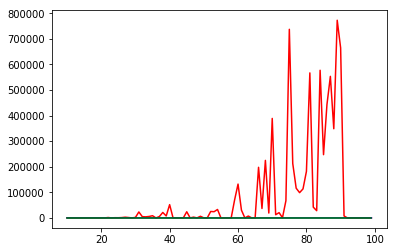

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

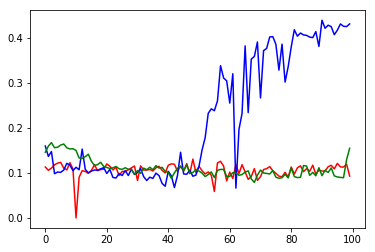

In [11]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/shufflenet_v2_ssdlight_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/shufflenet_v2_ssdlight_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 563s 563ms/step - loss: 5.3793
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 536s 536ms/step - loss: 4.7871
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 536s 536ms/step - loss: 4.6255
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 535s 535ms/step - loss: 4.4244
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 535s 535ms/step - loss: 4.2865
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 538s 538ms/step - loss: 4.2829
Epoch 7/80

Epoch 00007: LearningRateS

1000/1000 [==============================] - 534s 534ms/step - loss: 3.1810
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 530s 530ms/step - loss: 3.1671
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 535s 535ms/step - loss: 3.1611
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 536s 536ms/step - loss: 3.1684
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 539s 539ms/step - loss: 3.1470
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 534s 534ms/step - loss: 3.1243
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 535s 535ms/step - l